
=== Page 1 ===


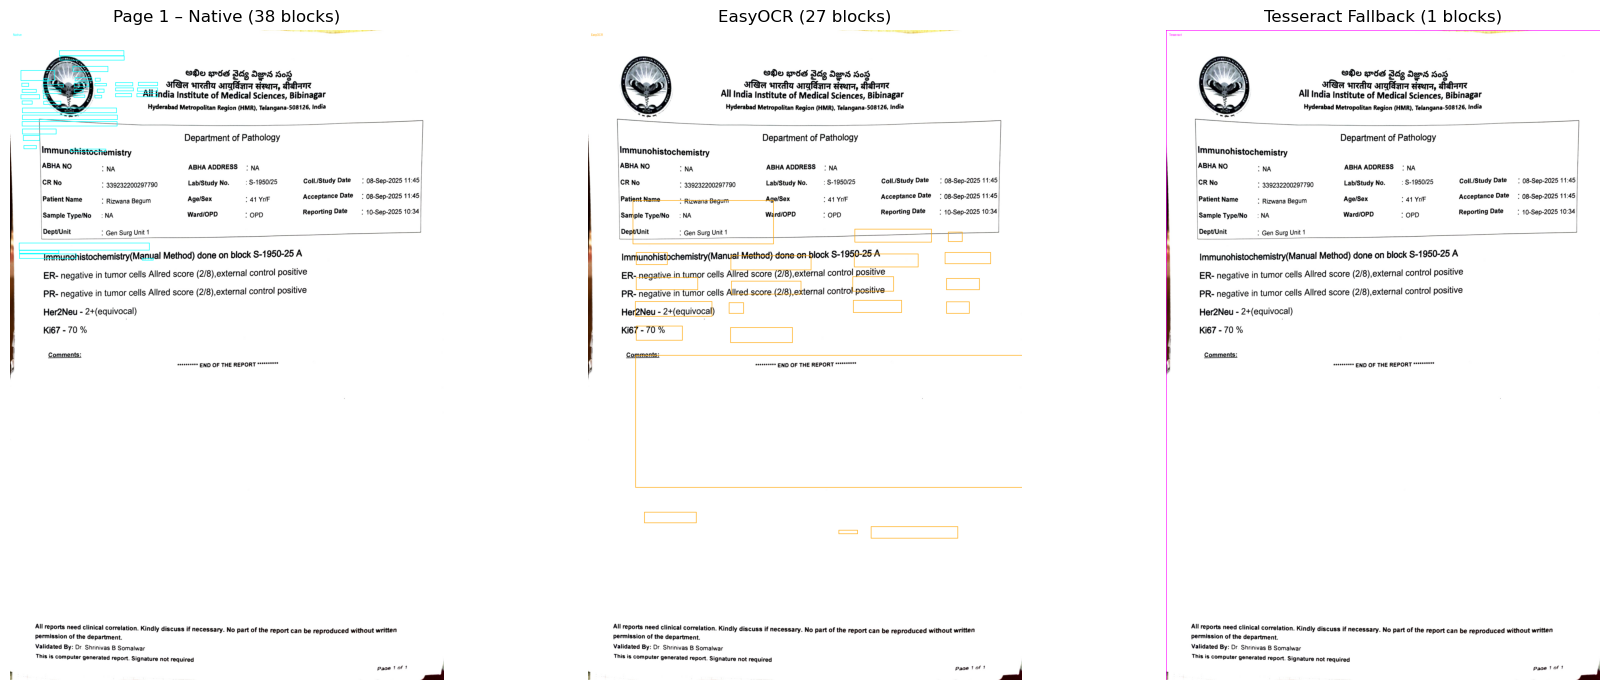


=== Page 2 ===


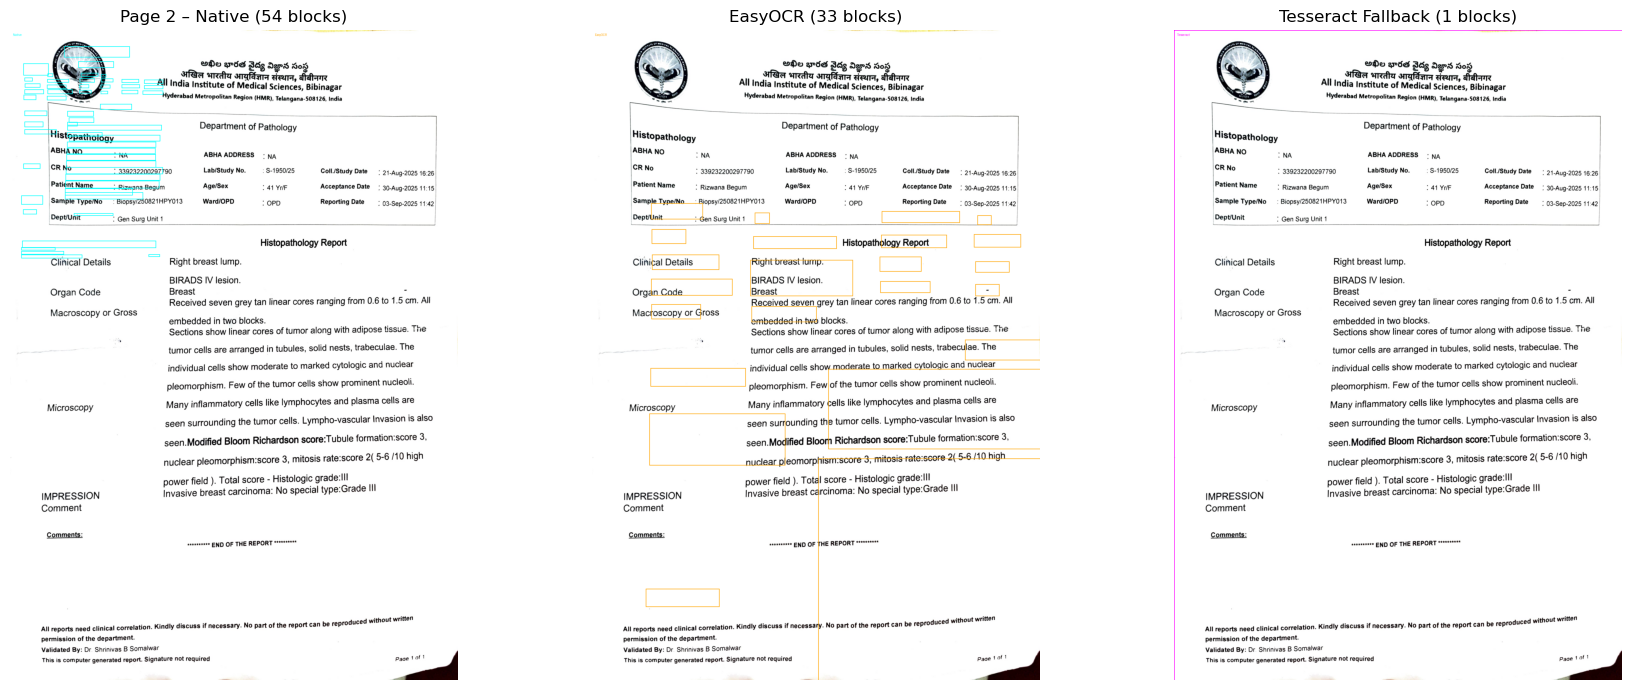


=== Page 3 ===


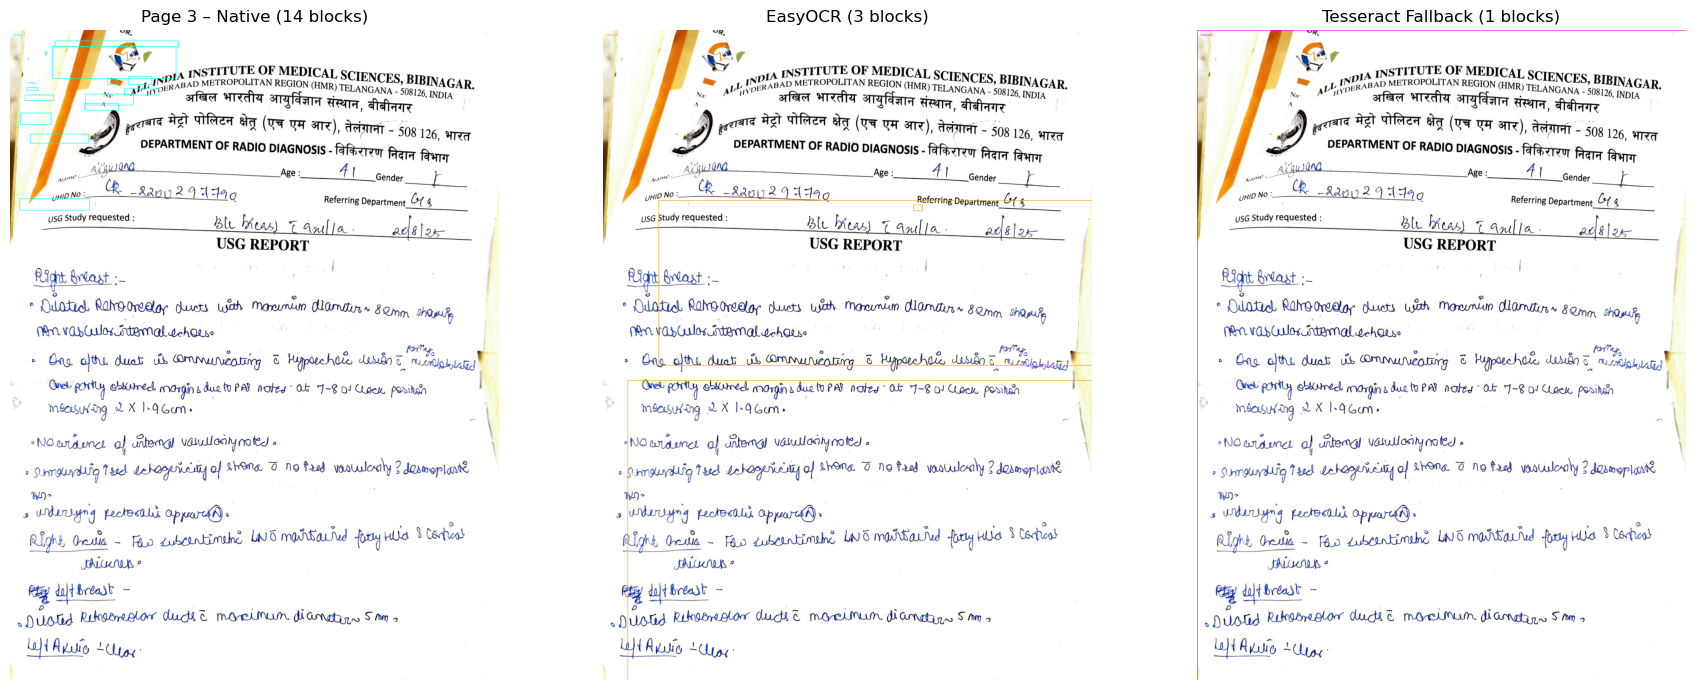


=== Page 4 ===


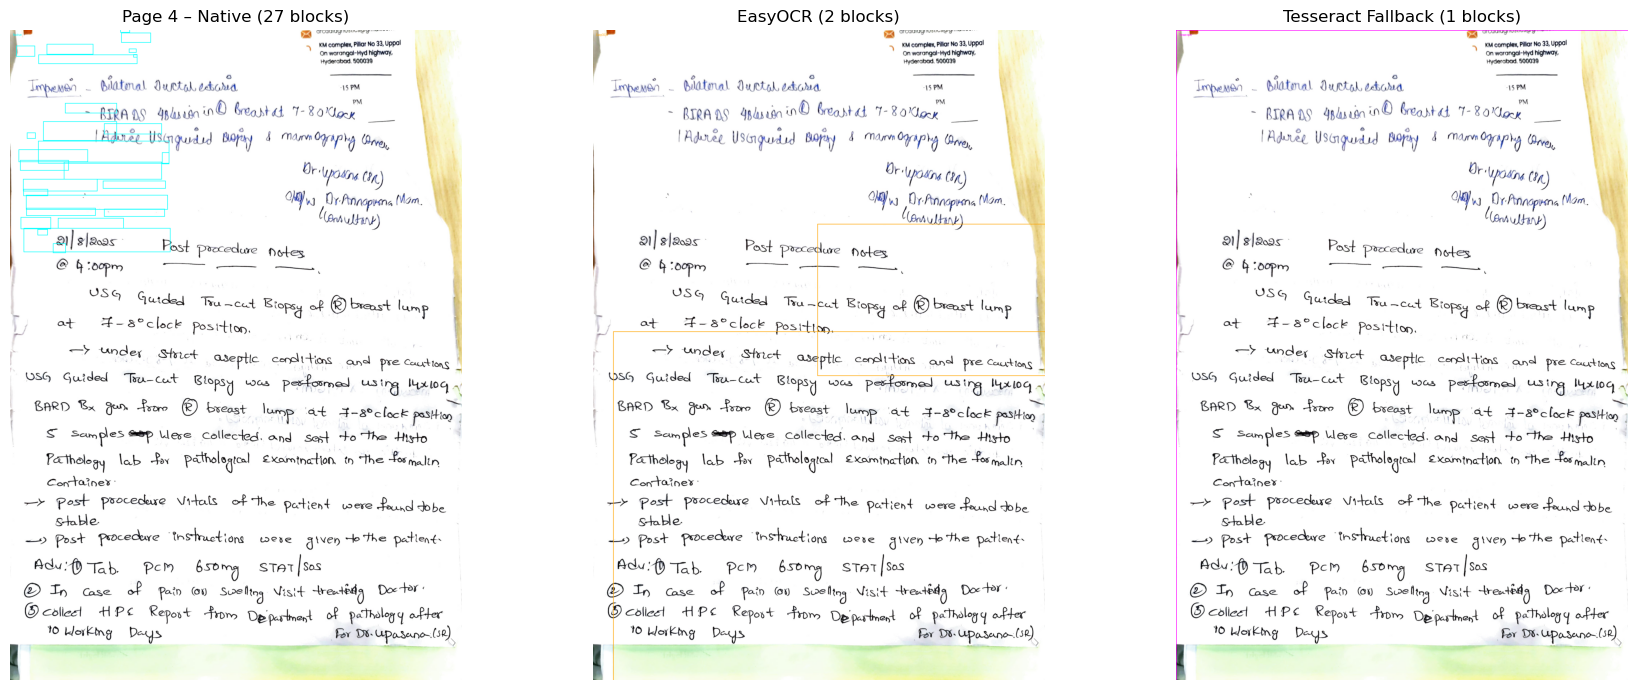

In [6]:
# =============================================
# 📋 01a_check_page_quality.ipynb
# Visual QA for Extraction (Native + OCR)
# =============================================

import json, fitz, easyocr
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from pathlib import Path

# --- CONFIG ---
pdf_path = Path("input_pdfs/ET1-Adobe Scan 10 Sept 2025.pdf")
blocks_dir = Path("outputs/run_001/01_blocks")
langs = ["en"]  # tweak for multilingual PDFs
dpi = 200
page_limit = 4  # visualize first N pages

# --- Utils ---
def page_to_image(doc, page_index, dpi=200):
    page = doc[page_index]
    zoom = dpi / 72
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat, alpha=False)
    return Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

def draw_blocks(img: Image.Image, blocks, color, label=None):
    draw = ImageDraw.Draw(img)
    for b in blocks:
        if not isinstance(b, dict): continue
        bbox = b.get("bbox") or []
        if len(bbox) != 4: continue
        x0,y0,x1,y1 = bbox
        draw.rectangle([x0,y0,x1,y1], outline=color, width=2)
    if label:
        draw.text((10, 10), label, fill=color)
    return img

def preview_page(img, native, ocr_easy, ocr_tess, page_num):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))
    axes = axes.flatten()
    axes[0].imshow(draw_blocks(img.copy(), native, "cyan", "Native"))
    axes[0].set_title(f"Page {page_num} – Native ({len(native)} blocks)")
    axes[1].imshow(draw_blocks(img.copy(), ocr_easy, "orange", "EasyOCR"))
    axes[1].set_title(f"EasyOCR ({len(ocr_easy)} blocks)")
    axes[2].imshow(draw_blocks(img.copy(), ocr_tess, "magenta", "Tesseract"))
    axes[2].set_title(f"Tesseract Fallback ({len(ocr_tess)} blocks)")
    for ax in axes: ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"outputs/run_001/01_blocks/qa_page_{page_num:03d}_viz.png")
    plt.show()

# --- OCR Helpers ---
def ocr_easyocr(pil_img, langs):
    reader = easyocr.Reader(langs, gpu=False)
    res = reader.readtext(np.array(pil_img), detail=1, paragraph=True)
    out = []
    for r in res:
        if len(r) < 2: continue
        bbox, text = r[0], r[1]
        xs = [p[0] for p in bbox]; ys = [p[1] for p in bbox]
        x0, y0, x1, y1 = min(xs), min(ys), max(xs), max(ys)
        out.append({"bbox": [x0,y0,x1,y1], "text": text})
    return out

def ocr_tesseract(pil_img):
    try:
        import pytesseract
        text = pytesseract.image_to_string(pil_img)
        if len(text.strip()) < 10:
            return []
        return [{"bbox": [0,0,pil_img.width,pil_img.height], "text": text}]
    except Exception:
        return []

# --- MAIN ---
doc = fitz.open(pdf_path)

for i in range(min(len(doc), page_limit)):
    page = doc[i]
    print(f"\n=== Page {i+1} ===")
    img = page_to_image(doc, i, dpi)

    # load native/ocr outputs if already saved
    native_path = blocks_dir / f"page_{i+1:03d}_native.json"
    ocr_easy_path = blocks_dir / f"page_{i+1:03d}_ocr_easy.json"
    ocr_tess_path = blocks_dir / f"page_{i+1:03d}_ocr_tess.json"

    native = json.loads(native_path.read_text()) if native_path.exists() else []
    ocr_easy = json.loads(ocr_easy_path.read_text()) if ocr_easy_path.exists() else []
    ocr_tess = json.loads(ocr_tess_path.read_text()) if ocr_tess_path.exists() else []

    # if missing, recompute inline
    if not ocr_easy:
        ocr_easy = ocr_easyocr(img, langs)
    if not ocr_tess:
        ocr_tess = ocr_tesseract(img)

    # show side-by-side preview
    preview_page(img, native, ocr_easy, ocr_tess, i+1)
